## Understanding the concepts of Bias, Variance, the Bias-Variance Tradeoff and Linear Regression

<img src="15 - Bias_Variance_BVTradeoff_LinearRegression.jpg" alt="Drawing" style="width: 700px;"/>

## A simple Linear Regression excerise 

In [1]:
import pandas as pd
import seaborn as sb

In [2]:
def get_df_info(df, include_unique_values=False):
    col_name_list = list(df.columns)
    col_type_list = [type(cell) for cell in df.iloc[0, :]]
    col_null_count_list = [df[col].isnull().sum() for col in col_name_list]
    col_unique_count_list = [df[col].nunique() for col in col_name_list]
    col_memory_usage_list = [df[col].memory_usage() for col in col_name_list]
    df_total_memory_usage = sum(col_memory_usage_list) / 1048576
    if include_unique_values:
        col_unique_list = [df[col].unique() for col in col_name_list]
        df_info = pd.DataFrame({'column_name': col_name_list, 'type': col_type_list, 
                                'null_count': col_null_count_list, 'nunique': col_unique_count_list, 
                                'unique_values': col_unique_list})
    else:
        df_info = pd.DataFrame({'column_name': col_name_list, 'type': col_type_list, 
                                'null_count': col_null_count_list, 'nunique': col_unique_count_list})
    return df_info, df_total_memory_usage

### 1 - EDA

In [3]:
df_shampoo_sales_raw_data = pd.read_csv('../data/shampoo_sales_data.csv')

In [4]:
df_shampoo_sales_raw_data.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [5]:
df_shampoo_sales_raw_data_info, df_shampoo_sales_raw_data_mem = get_df_info(df_shampoo_sales_raw_data, include_unique_values=True)
print('{} has {} row and {} cols, uses approx. {:.2f} MB'.format('df_shampoo_sales_raw_data', df_shampoo_sales_raw_data.shape[0],
                                                                 df_shampoo_sales_raw_data.shape[1], df_shampoo_sales_raw_data_mem))
df_shampoo_sales_raw_data_info

df_shampoo_sales_raw_data has 36 row and 2 cols, uses approx. 0.00 MB


,column_name,type,null_count,nunique,unique_values
0,Month,<class 'str'>,0,36,"[1-01, 1-02, 1-03, 1-04, 1-05, 1-06, 1-07, 1-0..."
1,Sales,<class 'numpy.float64'>,0,36,"[266.0, 145.9, 183.1, 119.3, 180.3, 168.5, 231..."


In [6]:
df_shampoo_sales_raw_data.describe()

,Sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


In [7]:
df_shampoo_sales_raw_data.describe(include='object')

,Month
count,36
unique,36
top,2-12
freq,1


### 2 - Preprocessing

In [8]:
df_shampoo_sales_pp = df_shampoo_sales_raw_data.copy()

In [9]:
df_shampoo_sales_pp['year'] = df_shampoo_sales_pp.Month.apply(lambda x: int(x[0]))
df_shampoo_sales_pp['month'] = df_shampoo_sales_pp.Month.apply(lambda x: int(x[2:]))
df_shampoo_sales_pp

,Month,Sales,year,month
0,1-01,266.0,1,1
1,1-02,145.9,1,2
2,1-03,183.1,1,3
3,1-04,119.3,1,4
4,1-05,180.3,1,5
5,1-06,168.5,1,6
6,1-07,231.8,1,7
7,1-08,224.5,1,8
8,1-09,192.8,1,9
9,1-10,122.9,1,10


In [10]:
df_shampoo_sales_pp['year_month'] = df_shampoo_sales_pp.Month.apply(lambda x: int(x[0]+x[2:]))
df_shampoo_sales_pp

,Month,Sales,year,month,year_month
0,1-01,266.0,1,1,101
1,1-02,145.9,1,2,102
2,1-03,183.1,1,3,103
3,1-04,119.3,1,4,104
4,1-05,180.3,1,5,105
5,1-06,168.5,1,6,106
6,1-07,231.8,1,7,107
7,1-08,224.5,1,8,108
8,1-09,192.8,1,9,109
9,1-10,122.9,1,10,110


In [11]:
df_shampoo_sales_pp['year_month_new'] = [ym for ym in range(1, 37)]
df_shampoo_sales_pp

,Month,Sales,year,month,year_month,year_month_new
0,1-01,266.0,1,1,101,1
1,1-02,145.9,1,2,102,2
2,1-03,183.1,1,3,103,3
3,1-04,119.3,1,4,104,4
4,1-05,180.3,1,5,105,5
5,1-06,168.5,1,6,106,6
6,1-07,231.8,1,7,107,7
7,1-08,224.5,1,8,108,8
8,1-09,192.8,1,9,109,9
9,1-10,122.9,1,10,110,10


#### We will use year_month_new as our feature for regression modelling as it is the simplest (when compared with two features - year and month or even year_month)

### 3 - Regression Analysis

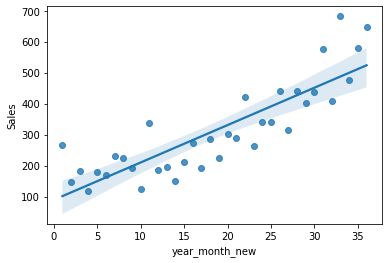

In [12]:
sb.regplot(x=df_shampoo_sales_pp.year_month_new, y=df_shampoo_sales_pp.Sales)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

#### initialize model object
#### create the model by fitting the data (model training)

In [14]:
lr_model_1 = LinearRegression()
lr_model_1.fit(df_shampoo_sales_pp.year_month_new.values.reshape(-1, 1), y=df_shampoo_sales_pp.Sales)
print(lr_model_1.coef_, lr_model_1.intercept_) # m & b (in y = mx + b)

[12.07907336] 89.13714285714283


#### Predicted values are calculated using the formula y = mx + b 

<pre>
y = 12.08 * 0  + 89.14 = 89.14
y = 12.08 * 1  + 89.14 = 101.22
y = 12.08 * 30 + 89.14 = 451.54
y = 12.08 * 40 + 89.14 = 572.34
</pre>

In [15]:
lr_model_1.predict(np.array([0, 1, 30, 40]).reshape(-1, 1))

array([ 89.13714286, 101.21621622, 451.50934363, 572.30007722])

In [16]:
df_shampoo_sales_pp.iloc[[0, 29], [1, 5]]

,Sales,year_month_new
0,266.0,1
29,437.4,30


In [17]:
y_hat = lr_model_1.predict(df_shampoo_sales_pp.year_month_new.values.reshape(-1, 1))

#### Overlaid regplot to compare seborn's regression model and one we created using sklearn. Note that the linear model by Seaborn is identical to the linear model we created using sklearn. This is true for this particular case, but may not be true for other cases.

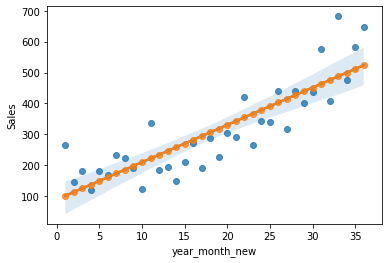

In [18]:
sb.regplot(x=df_shampoo_sales_pp.year_month_new, y=df_shampoo_sales_pp.Sales)
sb.regplot(x=df_shampoo_sales_pp.year_month_new, y=y_hat)

In [19]:
mean_absolute_error(df_shampoo_sales_pp.Sales, y_hat)

62.13656799656798

In [20]:
r2_score(df_shampoo_sales_pp.Sales, y_hat)

0.7301028704508052

#### Residuals or errors between actual and predicted values. The shape of the plot also tells us about the model 'goodness', ideal shape would be a flat line, where all residuals are near 0 and there is a symmetry between negative and positive residuals. In this case, the shape is a little like a curve, and the symmetry is also not perfect. But this does not necessarily mean that our model is bad. In fact, it's quite good!

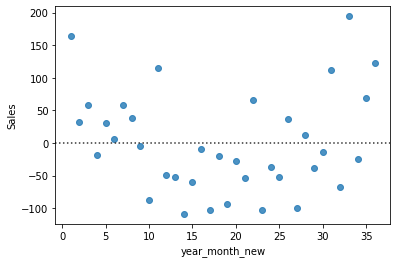

In [21]:
sb.residplot(x=df_shampoo_sales_pp.year_month_new, y=df_shampoo_sales_pp.Sales)

##### Comparision of residual plot created by seaborn automatically with the residual plot using predicted values from sklearn's model (they are identical)

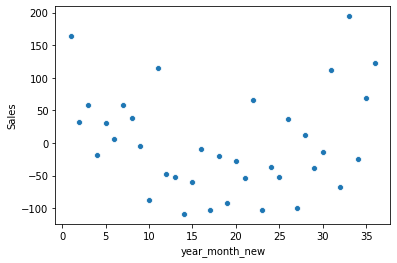

In [22]:
y_residuals = df_shampoo_sales_pp.Sales - y_hat
sb.scatterplot(df_shampoo_sales_pp.year_month_new, y_residuals)